In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
import os

In [3]:
class Vehicle:
    _id_counter = 0
    """Define vehicle attributes and rules to be implemented"""
    def __init__(self, x_position, speed, max_speed, length, width, road_designation, vehicle_type, current_row, lane_changing_prob):
        self.vehicle_id = Vehicle._id_counter  # Assign a unique ID to each vehicle
        Vehicle._id_counter += 1  #Increment the counter for the next vehicle
        self.x_position = x_position #position along the length of the road (x position)
        self.speed = speed #number of cells the vehicle will move per timestep
        self.max_speed = max_speed #maximum speed
        self.braking_prob = 0.01 #probability of random slowdown
        self.length = length #length of the vehicle is the number of cells the vehicle occupies along the length of the road
        self.width = width #width of the vehicle is the number of cells the vehicle occupies along the width of the road
        self.road_designation = road_designation #whether inside or outside
        self.vehicle_type = vehicle_type #type of vehicle is determined by the size and behavior
        self.current_row = current_row #also known as the y position of the right side of the vehicle
        #self.lane_changing_prob = lane_changing_prob #probability that a vehicle will transfer lane
        #print(f" {self.vehicle_type} {self.vehicle_id} attributes")
        
    def accelerate(self):
        """Increases vehicle's speed by 1 cell, up to the maximum speed"""
        if self.speed < self.max_speed:
            self.speed += 1

    def gap_distance(self, vehicle_row_to_be_checked): 
        """Debugging this - make gap distance consider toroidal boundary cond. recently introduced"""
        """vehicle row to be checked: Input is row 0, you check for lane 1(row 0 and 1). Input is row 1, you check for lane at the middle (row 1 and 2). Input is row 2, you check for lane 2(rows 2 and 3)."""
        rear_bumper_position = self.x_position
        #print(f"{self.vehicle_type} {self.vehicle_id}'s rear bumper is at {rear_bumper_position}")
        front_bumper_position = rear_bumper_position + self.length - 1
        #print(f"{self.vehicle_type} {self.vehicle_id}'s front bumper is at {front_bumper_position}")
        max_distance = self.speed #maximum distance checked is equivalent to speed
        #print(f"{self.vehicle_type} {self.vehicle_id}'s maximum distance is  {max_distance}")
        road_length = self.road_designation.road_length
        #print(f"{self.vehicle_type} {self.vehicle_id}'s road has length of {road_length}")
        
        gap_distance = max_distance
        #print(f"{self.vehicle_type} {self.vehicle_id}: default gap distance is {gap_distance}")
        
        for distance in range(1, max_distance + 1):
            start_of_space_to_be_checked = (rear_bumper_position + self.length + distance)  % road_length
            #print(f"{self.vehicle_type} {self.vehicle_id}: next rear bumper position is {start_of_space_to_be_checked}")
            end_of_space_to_be_checked = (front_bumper_position + max_distance)  % road_length #We have to include the front bumper position, to avoid vehicle overlaps
            #print(f"{self.vehicle_type} {self.vehicle_id}: next front bumper position is {end_of_space_to_be_checked}")
            
            # Check if there's an occupied space within the distance
            if start_of_space_to_be_checked < end_of_space_to_be_checked:
                #print(f"Checking occupancy from {start_of_space_to_be_checked} to {end_of_space_to_be_checked} in row {vehicle_row_to_be_checked}")
                #print(self.road_designation.road_occupancy[start_of_space_to_be_checked, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width])
                if np.sum(self.road_designation.road_occupancy[start_of_space_to_be_checked, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width]) != 0:
                    gap_distance = distance - 1
                    #print(f" The gap distance of {self.vehicle_type} {self.vehicle_id} is {gap_distance}")
                    break
            else:  # Wrap-around case
                #print(f"Checking occupancy wrap-around from {start_of_space_to_be_checked} to end and from start to {end_of_space_to_be_checked} in row {vehicle_row_to_be_checked}")
                #print(self.road_designation.road_occupancy[start_of_space_to_be_checked:, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width])
                #print(self.road_designation.road_occupancy[:end_of_space_to_be_checked + 1, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width])
                if np.sum(self.road_designation.road_occupancy[start_of_space_to_be_checked, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width]) != 0: #or \
                   #np.sum(self.road_designation.road_occupancy[:end_of_space_to_be_checked + 1, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width]) != 0:
                    gap_distance = distance - 1
                    #print(f" The gap distance of {self.vehicle_type} {self.vehicle_id} is {gap_distance}")
                    break
        #if min(gap_distance_row_1, gap_distance_row_2) < 0: #For debugging
            #print(gap_distance_row_1, gap_distance_row_2, current_x_position) #Results to negative headway distance
        #print(min(gap_distance_row_1, gap_distance_row_2))
        return gap_distance # Return the  gap distance

    def lane_changing(self):
        """attempts to change lanes based on vehicle type and lane availability
        Here, we define a lane as a space of 2 cells wide. We assume a two-lane road(4 cells wide).
        We assume that each half lane is an array, imagine a vertical stack of arrays, indexing is 0 to 4 (bottom to top). Right side is the bottom."""
        new_row = self.current_row #by default, vehicle stays on its lane
        gap_distance_of_own_lane = self.gap_distance(self.current_row) #obtains the gap distance of current lane
        #print(f"{self.vehicle_type}{self.vehicle_id} has a gap distance of {gap_distance_of_own_lane} in its lane, row is {self.current_row}")
        gap_distance_of_adjacent_right_lane = self.gap_distance(self.current_row - 1) if self.current_row > 0 else gap_distance_of_own_lane
        #print(f" The right row(and its corresponding lane) of {self.vehicle_type} {self.vehicle_id} has an available space of {gap_distance_of_adjacent_right_lane} cells in row {self.current_row-1} .")
        gap_distance_of_adjacent_left_lane = self.gap_distance(self.current_row + 1) if self.current_row < 2 else gap_distance_of_own_lane
        #print(f" The left row(and its corresponding lane) of {self.vehicle_type} {self.vehicle_id} has an available space of {gap_distance_of_adjacent_left_lane} cells in row {self.current_row+1} .")
        if self.speed > gap_distance_of_own_lane:
            if self.current_row == 0 and gap_distance_of_adjacent_left_lane > gap_distance_of_own_lane:#There are specific cases wherein changing to the right or left lane is possible/legal
                new_row = self.current_row + 1
                #print(f" Vehicle {self.vehicle_id} in row {self.current_row} switches to row {new_row}")
            elif self.current_row == 2 and gap_distance_of_adjacent_right_lane > gap_distance_of_own_lane: 
                new_row = self.current_row - 1
                #print(f" Vehicle {self.vehicle_id} in row {self.current_row} switches to row {new_row}")
            elif self.current_row == 1 and gap_distance_of_own_lane < max(gap_distance_of_adjacent_right_lane, gap_distance_of_adjacent_left_lane):
                if gap_distance_of_adjacent_right_lane > gap_distance_of_adjacent_left_lane:
                    new_row = self.current_row - 1
                    #print(f" Vehicle {self.vehicle_id} in row {self.current_row} switches to row {new_row}")
                elif gap_distance_of_adjacent_right_lane < gap_distance_of_adjacent_left_lane:
                    new_row = self.current_row + 1
                    #print(f" Vehicle {self.vehicle_id} in row {self.current_row} switches to row {new_row}")
        # Check for space on the new lane
        if np.sum(self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, new_row]) == 0:
            self.current_row = new_row

        #For debugging:
        #if self.speed < gap_distance_of_own_lane:
            #print(vehicle.gap_distance, gap_distance_of_own_lane, vehicle.speed)
        #if gap_distance_of_own_lane < 0:
            #print(f"{self.vehicle_type} {vehicle.vehicle_id} invalid")

    def decelerate(self):
        """decreases vehicle's speed to match the gap distance, given the speed>gap distance"""
        gap_distance_of_own_lane = self.gap_distance(self.current_row)
        if self.speed > gap_distance_of_own_lane:
            self.speed = gap_distance_of_own_lane

    def braking(self):
        """Mimics random slowdown, randomly decreases vehicle's speed based on braking probability """
        if np.random.rand() < self.braking_prob and self.speed > 0:
            self.speed -= 1
            #print(f"{self.vehicle_type} {self.vehicle_id} is braking")


    def move(self):
        """implements movement"""
        new_position = (self.x_position + self.speed) % self.road_designation.road_length
        self.x_position = new_position

In [4]:
class Road:
    def __init__(self, road_length, road_width, speed_limit):
        self.road_length = road_length
        self.road_width = road_width
        self.speed_limit = speed_limit
        self.road_occupancy = np.zeros((road_length, road_width))

In [5]:
class ThroughputCounter:
    def __init__(self, position):
        self.position = position  # The position where we count vehicles
        self.total_vehicles = 0   # Total vehicles passing through the position

    def count_vehicle(self, vehicle):
        # Check if the vehicle has crossed the position at this timestep
        if vehicle.x_position == self.position:
            self.total_vehicles += 1

    def calculate_average_throughput(self, total_timesteps):
        return self.total_vehicles / total_timesteps

In [6]:
class IntraRoadSimulator:
    def __init__(self, road):
        """This method stores the input agents and initializes output data"""
        self.road = road  # Store the road instance
        self.vehicles = []  # List to store vehicle instances
        self.occupancy_history = []  # List to store the history of road occupancy states
        #self.throughput_counter = ThroughputCounter(position=99)

    def update_occupancy(self):
        """This method updates road occupancy based on vehicle position and length"""
        self.road.road_occupancy.fill(0)
        for vehicle in self.vehicles:
            x_start = vehicle.x_position
            x_end = (vehicle.x_position + vehicle.length) % self.road.road_length #from vehicle rear bumper(position|) to front, minus 1. takes account of toroidal boundaries
            y_start = vehicle.current_row
            y_end = min(vehicle.current_row + vehicle.width, self.road.road_width)
            if x_start < x_end:
                if vehicle.vehicle_type == "jeep":
                    self.road.road_occupancy[x_start:x_end, y_start:y_end] = 1
                else:
                    self.road.road_occupancy[x_start:x_end, y_start:y_end] = 2
            else:
                if vehicle.vehicle_type == "jeep":
                    self.road.road_occupancy[x_start:, y_start:y_end] = 1
                    self.road.road_occupancy[:x_end, y_start:y_end] = 1
                else:
                    self.road.road_occupancy[x_start:, y_start:y_end] = 2
                    self.road.road_occupancy[:x_end, y_start:y_end] = 2
        self.occupancy_history.append(self.road.road_occupancy.copy())

    def initialize_vehicles(self, density, truck_fraction, truck_lane_change_prob, jeep_lane_change_prob):
        A, B = 7 * 2, 3 * 2  # Constants for truck and jeep area
        L, W = self.road.road_length, self.road.road_width  # Road dimensions
        N = int(density * L * W * (truck_fraction / A + (1 - truck_fraction) / B))  # Number of vehicles based on density and truck fraction
        for _ in range(int(N*truck_fraction)):
            vehicle_type = 'truck'
            length = 7
            width = 2
            #x_position = np.random.randint(0, self.road.road_length)  # Random initial position
            speed = np.random.randint(1, self.road.speed_limit + 1)
            lane_changing_prob = truck_lane_change_prob
            current_row = 0 
            found_position = False
            for x_position in range(self.road.road_length):
            # Check if the road portion is empty (no overlap with other vehicles)
                if self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width].sum() == 0:
                    # Found a valid position, place the truck here
                    new_vehicle = Vehicle(x_position, speed, self.road.speed_limit, length, width, self.road, vehicle_type, current_row, lane_changing_prob)
                    self.vehicles.append(new_vehicle)
                    # Mark the road occupancy for this truck
                    self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width] = 2
                    found_position = True
                    break

            if not found_position:
                print("Could not place a truck, no space available.")

        for _ in range(int(N*(1-truck_fraction))):
            vehicle_type = 'jeep'  # Randomly decide vehicle type
            length = 3
            width = 2
            #x_position = np.random.randint(0, self.road.road_length)  # Random initial position
            speed = np.random.randint(1, self.road.speed_limit + 1)
            lane_changing_prob = jeep_lane_change_prob
            current_row = 0 
            found_position = False
            
            for x_position in range(self.road.road_length):
            # Check if the road portion is empty (no overlap with other vehicles)
                if self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width].sum() == 0:
                    # Found a valid position, place the truck here
                    new_vehicle = Vehicle(x_position, speed, self.road.speed_limit, length, width, self.road, vehicle_type, current_row, lane_changing_prob)
                    self.vehicles.append(new_vehicle)
                    # Mark the road occupancy for this truck
                    self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width] = 1
                    found_position = True
                    break

            if not found_position:
                print("Could not place a jeep, no space available.")
                        
    def simulation_step(self):
        np.random.shuffle(self.vehicles)
        for vehicle in self.vehicles:
            vehicle.accelerate()  # Accelerate the vehicle
            #print(f"ACCELERATE DEBUGGER: {vehicle.vehicle_type} {vehicle.vehicle_id} has accelerated at a speed of {vehicle.speed}")
            #if np.random.rand() < vehicle.lane_changing_prob:
                #vehicle.lane_changing()  # Change lane if possible
                #vehicle.decelerate() # Decelerate if necessary
            #else:
            vehicle.decelerate()  # Decelerate if not changing lanes
                #print(f"{vehicle.vehicle_type} {vehicle.vehicle_id} is decelerating on own lane")
            # Apply brakes
            vehicle.braking()    
            #self.update_occupancy()
            #print(f"BEFORE MOVE DEBUGGER: {vehicle.vehicle_type} {vehicle.vehicle_id} is at position {vehicle.x_position}")
            #self.throughput_counter.count_vehicle(vehicle)
            vehicle.move()  # Move the vehicle
            #print(f"AFTER MOVE DEBUGGER: {vehicle.vehicle_type} {vehicle.vehicle_id} is at position {vehicle.x_position}, with a speed of {vehicle.speed} at row {vehicle.current_row}")
        self.update_occupancy()  # Update the road occupancy grid
        #self.throughput_counter.count_vehicles_at_timestep(self.vehicles)
        
    def visualize(self, step_count):
        plt.figure(figsize=(20, 6))
        plt.imshow(self.road.road_occupancy.T, cmap='gray_r', origin='lower')
        plt.title(f'Step {step_count}')
        plt.xlabel('Road Length')
        plt.ylabel('Lane')
        plt.xticks(range(0, self.road.road_length + 1, 1))
        plt.yticks(range(0, self.road.road_width + 1, 1))
        plt.tight_layout()
        plt.show()


In [7]:
# Define the road and density parameters
road = Road(road_length=100, road_width=4, speed_limit=5)
densities = np.linspace(0.1, 1.0, 10)  # Example range of densities
total_steps = 1000

# Open the CSV file and write the header
with open('fundamental_diagram_single_lane9.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Density', 'Throughput'])

    # Loop over each density, run the simulation, and write results to the CSV file
    for density in densities:
        simulator = IntraRoadSimulator(road)
        simulator.initialize_vehicles(density, truck_fraction=0.5, truck_lane_change_prob=0.9, jeep_lane_change_prob=0.9)

        throughput_counter = ThroughputCounter(position=99)

        for step in range(total_steps):
            simulator.simulation_step()

            for vehicle in simulator.vehicles:
                throughput_counter.count_vehicle(vehicle)

        average_throughput = throughput_counter.calculate_average_throughput(total_steps)
        
        # Write density and throughput to the CSV file
        writer.writerow([density, average_throughput])

Could not place a jeep, no space available.
Could not place a jeep, no space available.
Could not place a truck, no space available.
Could not place a truck, no space available.
Could not place a truck, no space available.
Could not place a truck, no space available.
Could not place a truck, no space available.
Could not place a truck, no space available.
Could not place a truck, no space available.
Could not place a truck, no space available.
Could not place a truck, no space available.
Could not place a jeep, no space available.
Could not place a truck, no space available.
Could not place a truck, no space available.
Could not place a jeep, no space available.
Could not place a jeep, no space available.
Could not place a jeep, no space available.
Could not place a jeep, no space available.
Could not place a jeep, no space available.
Could not place a jeep, no space available.
Could not place a jeep, no space available.
Could not place a truck, no space available.
Could not place a tr

STATIC CHECKER

Could not place a jeep, no space available.
Could not place a jeep, no space available.
Could not place a jeep, no space available.


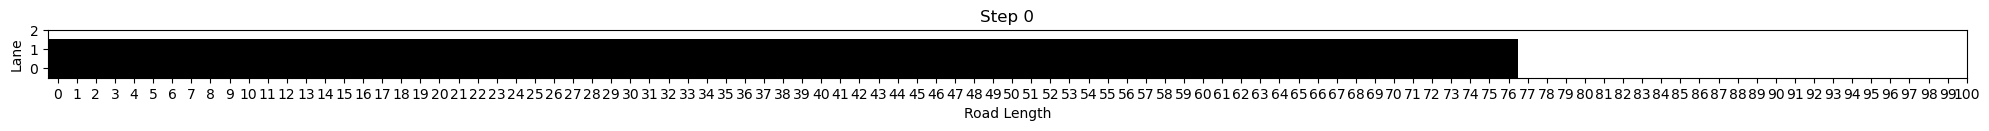

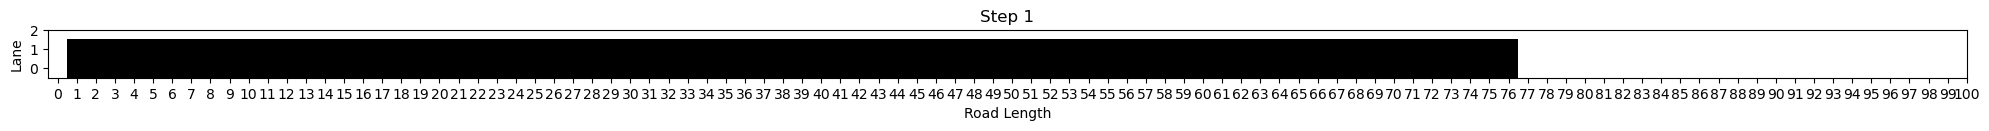

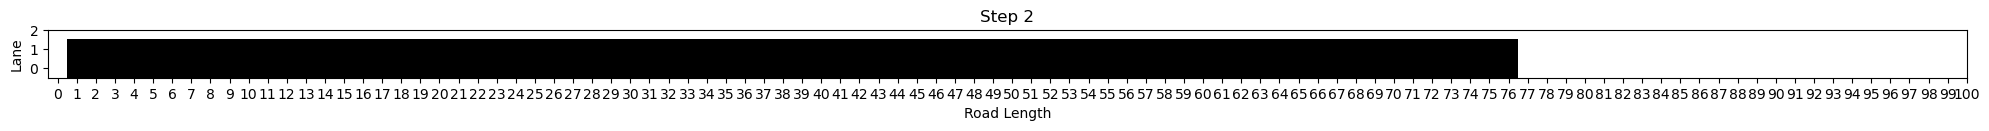

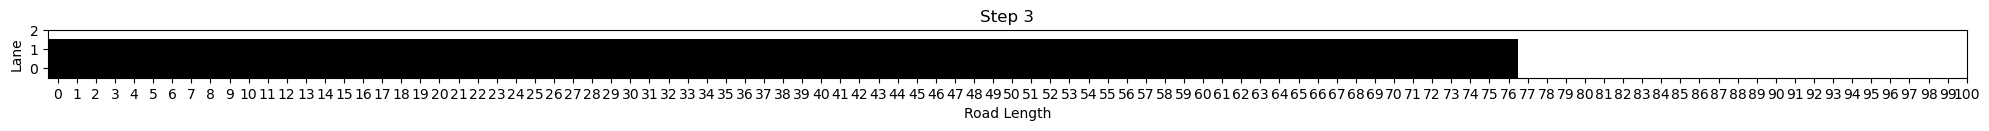

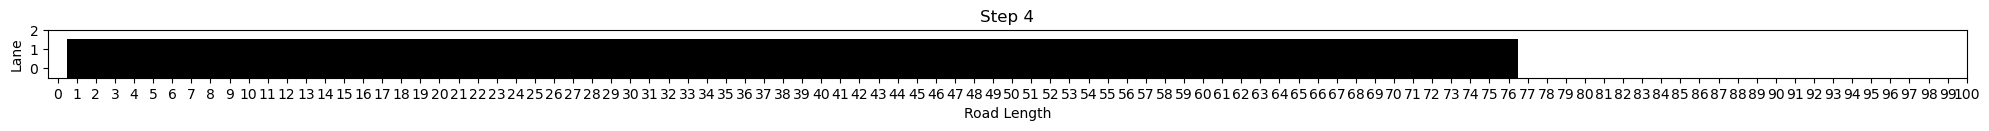

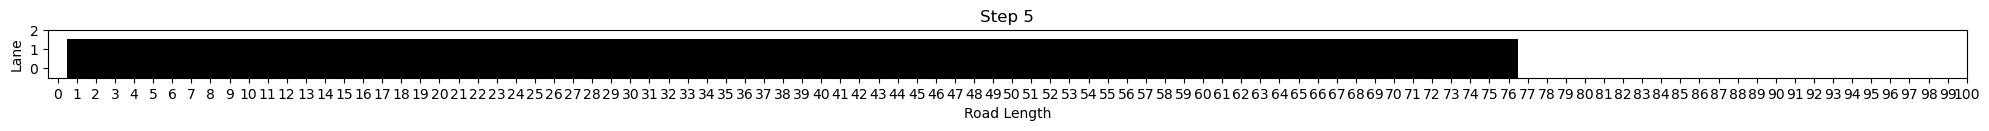

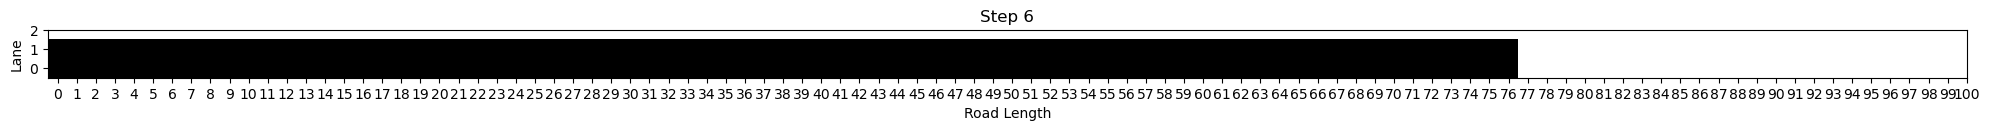

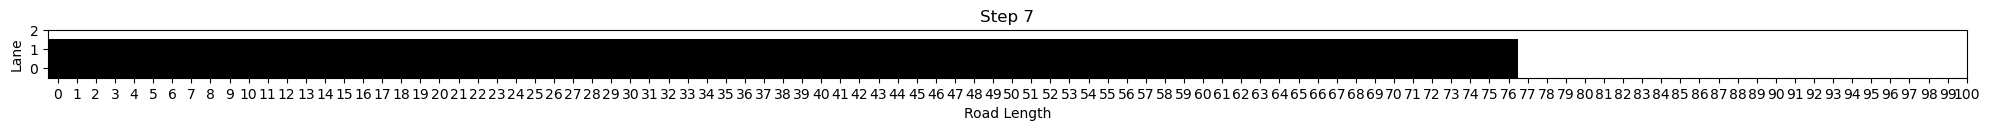

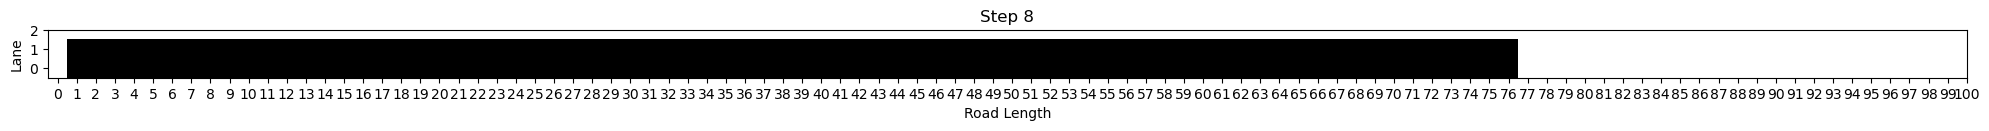

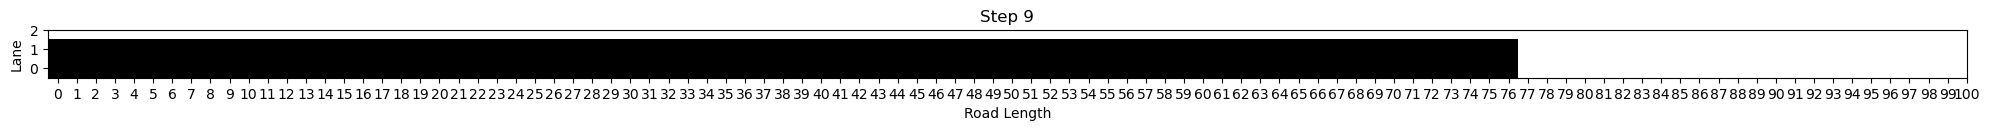

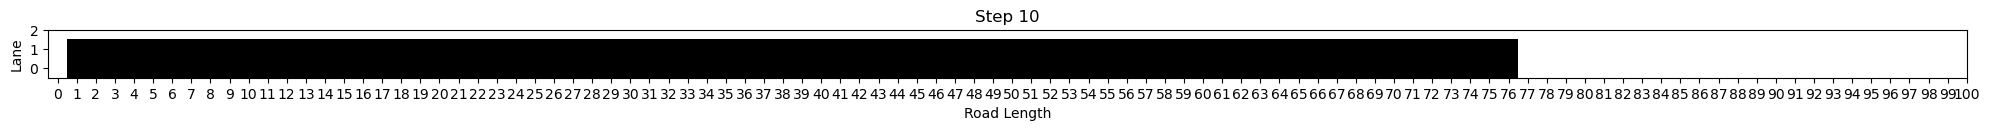

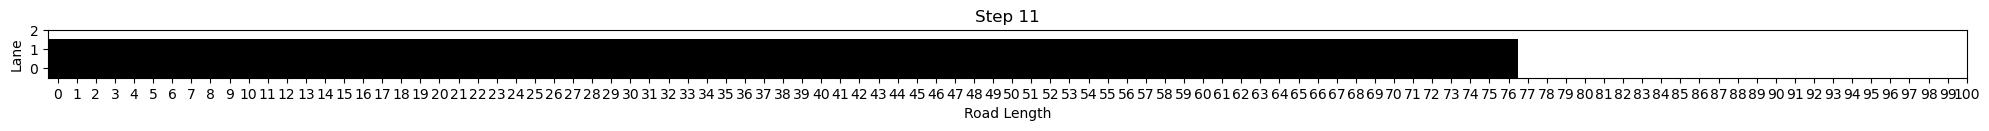

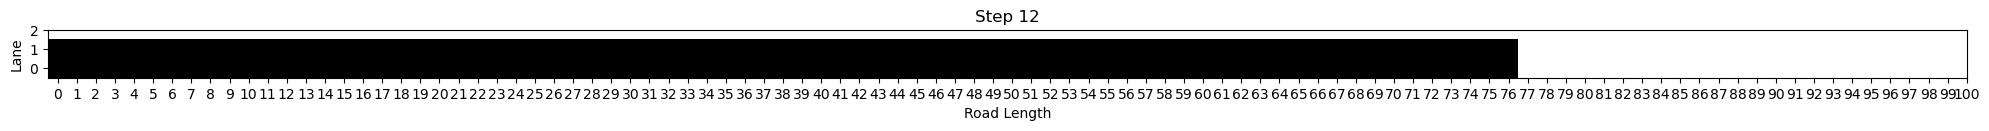

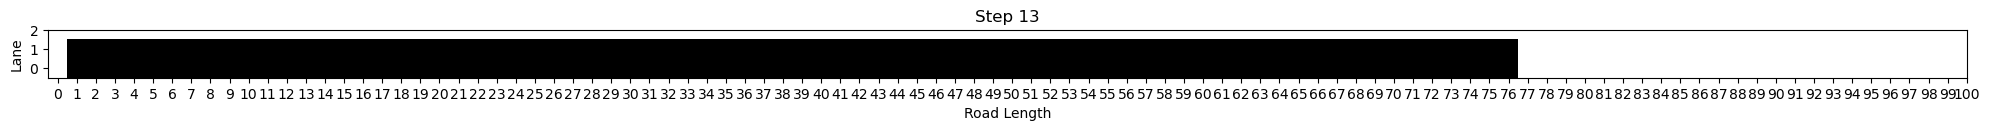

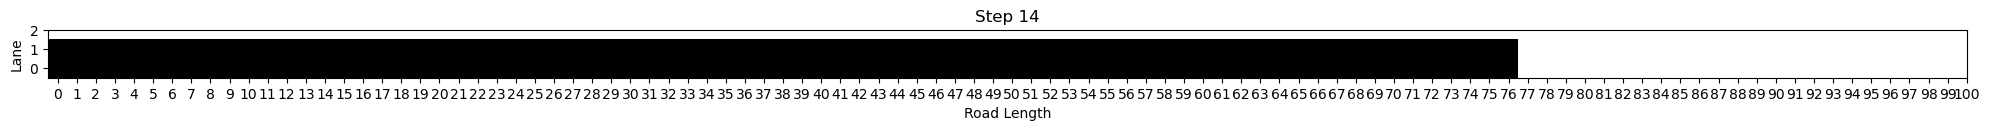

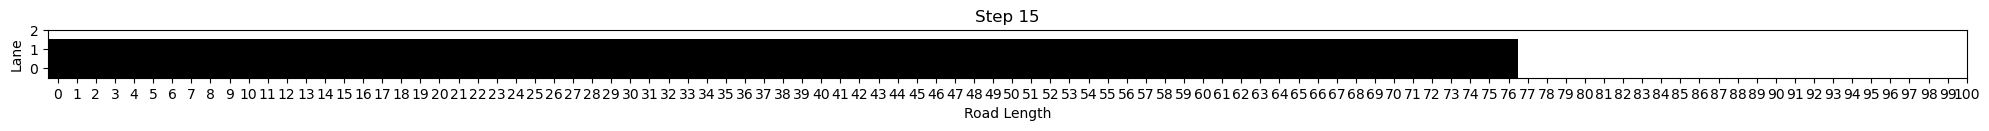

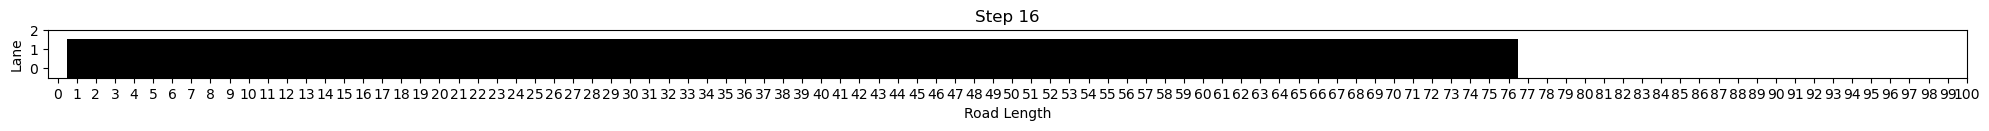

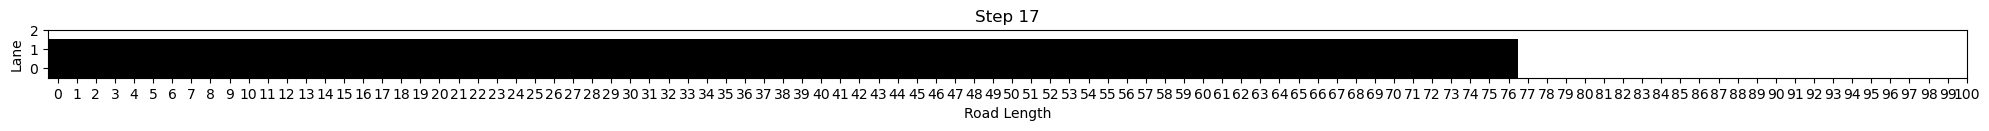

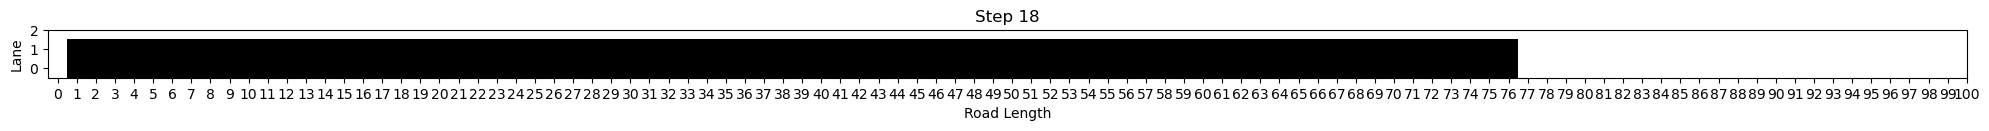

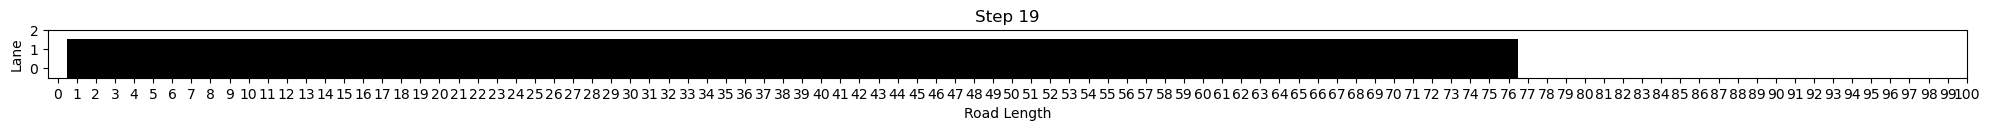

In [8]:
road = Road(road_length=100, road_width=2, speed_limit=5)
simulator = IntraRoadSimulator(road)

density = 1  # Example density
truck_fraction = 0.5 # Example truck fraction
timesteps = 20
simulator.initialize_vehicles(density, truck_fraction, 0.3, 0)
for step in range(timesteps):
    simulator.simulation_step()
    if step % 1 == 0:
        simulator.visualize(step)

MOVING CHECKER

In [ ]:
def animate(step):
    simulator.simulation_step()  # Run a simulation step
    ax.clear()  # Clear the previous plot
    ax.imshow(simulator.road.road_occupancy.T, cmap='gray_r', origin='lower')
    ax.set_title(f'Step {step}')
    ax.set_xlabel('Road Length')
    ax.set_ylabel('Lane')
    ax.set_xticks(range(0, simulator.road.road_length + 1, 1))
    ax.set_yticks(range(0, simulator.road.road_width + 1, 1))
    ax.grid(True)

# Initialize road and simulator
road = Road(road_length=50, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)

density = 1
truck_fraction = 1

simulator.initialize_vehicles(density, truck_fraction, 1, 0)  # Initialize vehicles

# Set up the figure and axis for animation
fig, ax = plt.subplots(figsize=(20, 6))

# Create the animation
anim = FuncAnimation(fig, animate, frames=100, interval=300)

# Save the animation as a GIF or MP4
anim.save('road_simulation_vehicle_only(truck fraction = 1, density = 1).gif', writer='pillow')
# Or save as MP4
# anim.save('road_simulation.mp4', writer='ffmpeg')

# Show the animation in a Jupyter notebook (if using one)
plt.show()